Используя знания из практической части урока и функцию blur_face (размытие), проведи следующий эксперимент:

    Найди фото любого известного актера или актрисы.

    Распознай лицо на фотографии. Выдели лицо овалом. Метод для рисования овала, найди самостоятельно.

    Выдели на изображении глаза. Выдели их кружком. Если ты чувствуешь в себе суперсилу и дополнительный бекграунд знаний, и хочешь получить больше баллов за задание, то нарисуй вместо кружков солнцезащитные очки (картинку очков можно найти в интернете, задача их правильно масштабировать и разместить).

    Все лицо кроме глаз необходимо "заблюрить" (размыть) с помощью функции. 

Оценка за задание:

    1 балл - задача решена с помощью куратора, лицо распознано прямоугольником, глаза кругом.

    2 балла - задача решена с незначительными подсказками куратора, лицо распознано прямоугольником или кругом, глаза кругом, лицо размыто.

    3 балла - задача решена самостоятельно, лицо распознано овалом, глаза кругом, удалось заблюрить лицо, не затронув глаза.

    4 балла - задача решена самостоятельно на 3 балла, удалось нарисовать очки с подсказкой куратора, недостаточна соблюдена симметрия расположения очков или недостаточно учтены их размеры.

    5 баллов - задача полностью решена самостоятельно, все пункты выполнены.



In [11]:
import os
import cv2
import gdown
from matplotlib import pyplot
import numpy as np

# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline
gdown.download('https://storage.yandexcloud.net/academy.ai/moustache.png', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/academy.ai/haarcascade_mcs_mouth.xml', None, quiet=True)

'haarcascade_mcs_mouth.xml'

In [91]:
#IMAGE_NAME = 'face_kidman.jpg'
#IMAGE_NAME = 'profile_green.jpg'
#IMAGE_NAME = '34_bardo.jpg'
#IMAGE_NAME = '34_jolie.jpg'
IMAGE_NAME = 'friends.jpg'

GLASSES_NAME = 'glasses_direct.png'
IMAGE_PATH = './photos/'
# Загрузка изображения
img = cv2.imread(os.path.join(IMAGE_PATH, IMAGE_NAME))
img2 = img.copy()

In [52]:
# загрузка каскада Хаара для поиска лиц
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")
# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")
# загрузка каскада Хаара для поиска улыбок
classifier_smile = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_smile.xml")
# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")
# загрузка каскада Хаара для поиска рта
classifier_mouth = cv2.CascadeClassifier("./haarcascade_mcs_mouth.xml")


In [ ]:
# выполнение распознавания лица
bboxes = classifier_face.detectMultiScale(img, scaleFactor=1.3, minNeighbors=3, minSize=(50, 50))
# Загрузим усы
moustache_mask = cv2.imread('./moustache.png')
h_mask, w_mask = moustache_mask.shape[:2]

# формирование прямоугольника вокруг каждого обнаруженного лица
for box in bboxes:
    # формирование координат
    x, y, width, height = box

    # найденная область с лицом
    face = img2[y:y + height, x:x + width]

    # нас интересует только 1/3 часть лица снизу
    # выполнение распознавания рта (только в нижней части лица)
    mouth_rects = classifier_mouth.detectMultiScale(img2[y+int(2*height/3):y + height, x:x + width], scaleFactor=1.3, minNeighbors=10, minSize=(20, 20))


    if len(mouth_rects) > 0:
        # Берем первый найденный объект, наиболее вероятное расположение рта
        (mx, my, mw, mh) = mouth_rects[0]
        mx -= int(0*mw) # сдвигать усы по оси х не будем
        my = int(2*height/3-5) # восстанавливаем координату относительно лица и немного приподнимаем усы на 5px

        # область рта
        mouth = face[my:my+mh, mx:mx+mw]

        # Маштабируем усы до размера рта
        moustache_mask_small = cv2.resize(moustache_mask, (mw, mh), interpolation=cv2.INTER_AREA)

        # Сделаем наши усы черно-белые и применим инвариантный бинарный порог, как это делали с номерами
        gray_mask = cv2.cvtColor(moustache_mask_small, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(gray_mask, 50, 255, cv2.THRESH_BINARY_INV)

        # Чтобы инвертировать маску в OpenCV, мы используем функцию cv2.bitwise_not(),
        # которая выполняет побитовую операцию not над отдельными пикселями.
        # https://docs.opencv.org/2.4.13.2/modules/core/doc/operations_on_arrays.html?highlight=bitwise#bitwise-not
        mask_inv = cv2.bitwise_not(mask)

        # побитовое AND для двух изображений, результирующая - пиксели присутствующие на обоих изображениях
        masked_mouth = cv2.bitwise_and(moustache_mask_small, moustache_mask_small, mask=mask)
        #  https://docs.opencv.org/2.4.13.2/modules/core/doc/operations_on_arrays.html?highlight=bitwise#bitwise-and
        masked_face = cv2.bitwise_and(mouth, mouth, mask=mask_inv)

        # Объединяем рот и усы
        face[my:my+mh, mx:mx+mw] = cv2.add(masked_mouth, masked_face)



fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Изображение с усами')

pyplot.show()

In [92]:
# выполнение распознавания лица
bboxes = classifier_face.detectMultiScale(img, scaleFactor=1.3, minNeighbors=3, minSize=(150, 100))
# формирование прямоугольника вокруг каждого обнаруженного лица
for box in bboxes:
    #print(box)
    # формирование координат
    x, y, width, height = box
    x2, y2 = x + width, y + height
    # рисование прямоугольников
    cv2.rectangle (img2, (x, y), (x2, y2), (0, 0, 255), 2)

    face = img2[y:y + height, x:x + width] # найденная область с лицом
    facetop = img2[y:int(y + height *2 / 3), x:x + width] # найденная область с лицом
#перекрестье глаз
    eyes = classifier_eye.detectMultiScale(facetop)
    centers = []
    for (x_eye, y_eye, w_eye, h_eye) in eyes:
        cx = int(x_eye + 0.5*w_eye)
        cy = int(y_eye + 0.5*h_eye)
        centers.append((cx, cy))

    if len(centers) >= 2:
        p1, p2 = centers[:2]            # два глаза
        color = (0, 255, 0)
        thickness = 2

        # линия между глазами
        cv2.line(face, p1, p2, color, thickness)

        # серединный перпендикуляр
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        mid = ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)   # середина
        length = int((dx**2 + dy**2) ** 0.5 * 1.5)          # длина перпендикуляра

        # нормаль (перпендикуляр к (dx, dy))
        norm = (dx**2 + dy**2) ** 0.5
        nx, ny = -dy / norm, dx / norm

        p3 = (int(mid[0] + nx * length / 2), int(mid[1] + ny * length / 2))
        p4 = (int(mid[0] - nx * length / 2), int(mid[1] - ny * length / 2))

        cv2.line(face, p3, p4, color, thickness)


In [ ]:

    # выполнение распознавания глаз
    eyes = classifier_eye.detectMultiScale(facetop)

    for (x_eye,y_eye,w_eye,h_eye) in eyes:
        print(eyes)
        # определяем центр круга
        center = (int(x_eye + 0.5*w_eye), int(y_eye + 0.5*h_eye))

        # вычисляем радиус окружности (подобран эмпирическим путем)
        radius = int(0.3 * (w_eye + h_eye))
        color = (0, 255, 0) # цвет в RGB (интенсивность цветов красный-зеленый-синий от 0 до 255)
        thickness = 3 # толщина линии
        # рисуем круг
        cv2.circle(face, center, radius, color, thickness)

        

[[ 48  53  47  47]
 [123  78  45  45]]
[[ 46  52  50  50]
 [122  78  46  46]]


In [89]:
#перекрестье глаз
eyes = classifier_eye.detectMultiScale(facetop)
centers = []
for (x_eye, y_eye, w_eye, h_eye) in eyes:
    cx = int(x_eye + 0.5*w_eye)
    cy = int(y_eye + 0.5*h_eye)
    centers.append((cx, cy))

if len(centers) >= 2:
    p1, p2 = centers[:2]            # два глаза
    color = (0, 255, 0)
    thickness = 2

    # линия между глазами
    cv2.line(face, p1, p2, color, thickness)

    # серединный перпендикуляр
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    mid = ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)   # середина
    length = int((dx**2 + dy**2) ** 0.5 * 1.5)          # длина перпендикуляра

    # нормаль (перпендикуляр к (dx, dy))
    norm = (dx**2 + dy**2) ** 0.5
    nx, ny = -dy / norm, dx / norm

    p3 = (int(mid[0] + nx * length / 2), int(mid[1] + ny * length / 2))
    p4 = (int(mid[0] - nx * length / 2), int(mid[1] - ny * length / 2))

    cv2.line(face, p3, p4, color, thickness)

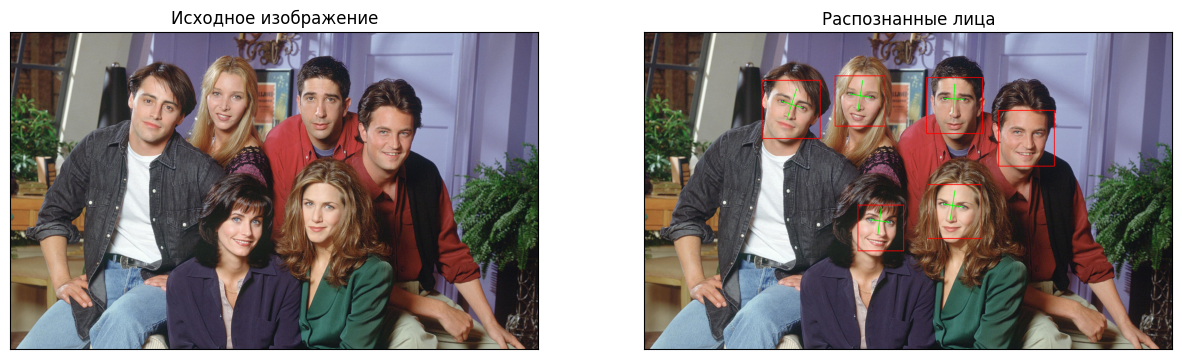

In [93]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Распознанные лица')

pyplot.show()

NameError: name 'img5' is not defined

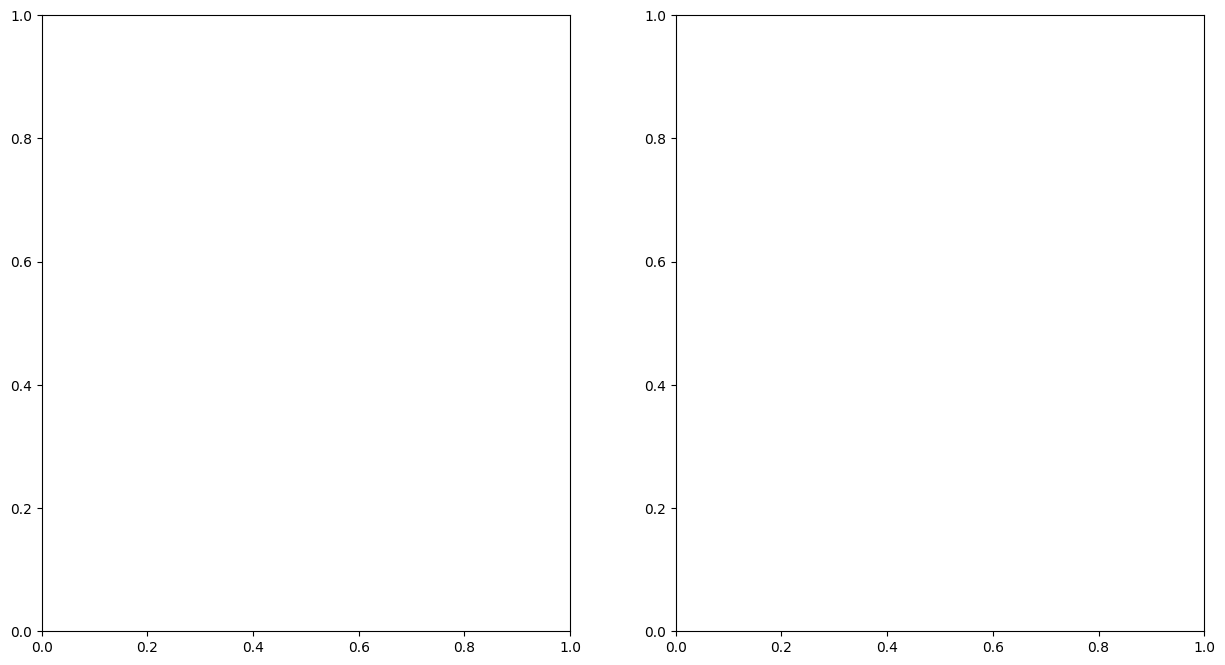

In [94]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

In [7]:
import cv2
import os

cascade_dir = cv2.data.haarcascades
print("Каталог каскадов:", cascade_dir)
print("Список файлов:")

for f in os.listdir(cascade_dir):
    if f.endswith(".xml"):
        print(f)

Каталог каскадов: /mnt/f/Github/LessonsHub/.venv/lib/python3.12/site-packages/cv2/data/
Список файлов:
haarcascade_eye.xml
haarcascade_eye_tree_eyeglasses.xml
haarcascade_frontalcatface.xml
haarcascade_frontalcatface_extended.xml
haarcascade_frontalface_alt.xml
haarcascade_frontalface_alt2.xml
haarcascade_frontalface_alt_tree.xml
haarcascade_frontalface_default.xml
haarcascade_fullbody.xml
haarcascade_lefteye_2splits.xml
haarcascade_license_plate_rus_16stages.xml
haarcascade_lowerbody.xml
haarcascade_profileface.xml
haarcascade_righteye_2splits.xml
haarcascade_russian_plate_number.xml
haarcascade_smile.xml
haarcascade_upperbody.xml
